In [1]:
import sqlite3
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dot_density_mapping import gen_points_in_gdf_polys, gen_random_points_poly

import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# read in geodata
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)

In [3]:
def compile_single_msoa_traveltimes(direction, target_msoa, ttm, msoa_boundaries = msoas):
    '''Compiles a geodataframe of travel times to or from a target msoa.
    target_msoa is an MSOA ID, direction is "from" or "to", ttm is a travel time matrix containing at least "orig_id" and 
    "dest_id", msoa_boundaries is a geodataframe of MSOA boundaries with MSOA IDs as index.'''
    if direction == 'to':
        output = ttm[ttm['dest_id'] == target_msoa]
        output.set_index('orig_id', inplace = True)
    elif direction == 'from':
        output = ttm[ttm['orig_id'] == target_msoa]
        output.set_index('dest_id', inplace = True)
    output = msoa_boundaries.join(output)
    return output

In [4]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

In [5]:
traveltime_cutoff = 45 # cutoff for considering which MSOAs are accessible from each MSOA

### Fig XX: Travel Times to/from City

In [6]:
# read in minimum travel time data
db = sqlite3.connect('../../../../../data/London/TfL/TfL API/Travel Options/20190322_0830/traveloptions.db')
baseline_fastestoption_ampeak = pd.read_sql("SELECT orig_id, dest_id, option_id, fare, MIN(traveltime) FROM traveloptions WHERE legs_cycle == 0 GROUP BY orig_id, dest_id", db)
db.close()

db = sqlite3.connect('../../../../../data/London/TfL/TfL API/Travel Options/20190322_1330/traveloptions.db')
baseline_fastestoption_offpeak = pd.read_sql("SELECT orig_id, dest_id, option_id, MIN(traveltime) FROM traveloptions WHERE legs_cycle == 0 GROUP BY orig_id, dest_id", db)
db.close()

In [7]:
np.sum(baseline_fastestoption_ampeak[baseline_fastestoption_ampeak['fare'] > 800]['MIN(traveltime)'] < 45)

16

In [8]:
# compile travel times for City
baseline_fastestoption_ampeak_to_city = compile_single_msoa_traveltimes('to', 'E02000001', baseline_fastestoption_ampeak)
baseline_fastestoption_offpeak_to_city = compile_single_msoa_traveltimes('to', 'E02000001', baseline_fastestoption_offpeak)
baseline_fastestoption_offpeak_to_city['traveltime_offpeak_vs_ampeak'] = baseline_fastestoption_offpeak_to_city['MIN(traveltime)'] / baseline_fastestoption_ampeak_to_city['MIN(traveltime)']

baseline_fastestoption_ampeak_from_city = compile_single_msoa_traveltimes('from', 'E02000001', baseline_fastestoption_ampeak)
baseline_fastestoption_offpeak_from_city = compile_single_msoa_traveltimes('from', 'E02000001', baseline_fastestoption_offpeak)
baseline_fastestoption_offpeak_from_city['traveltime_offpeak_vs_ampeak'] = baseline_fastestoption_offpeak_from_city['MIN(traveltime)'] / baseline_fastestoption_ampeak_from_city['MIN(traveltime)']

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

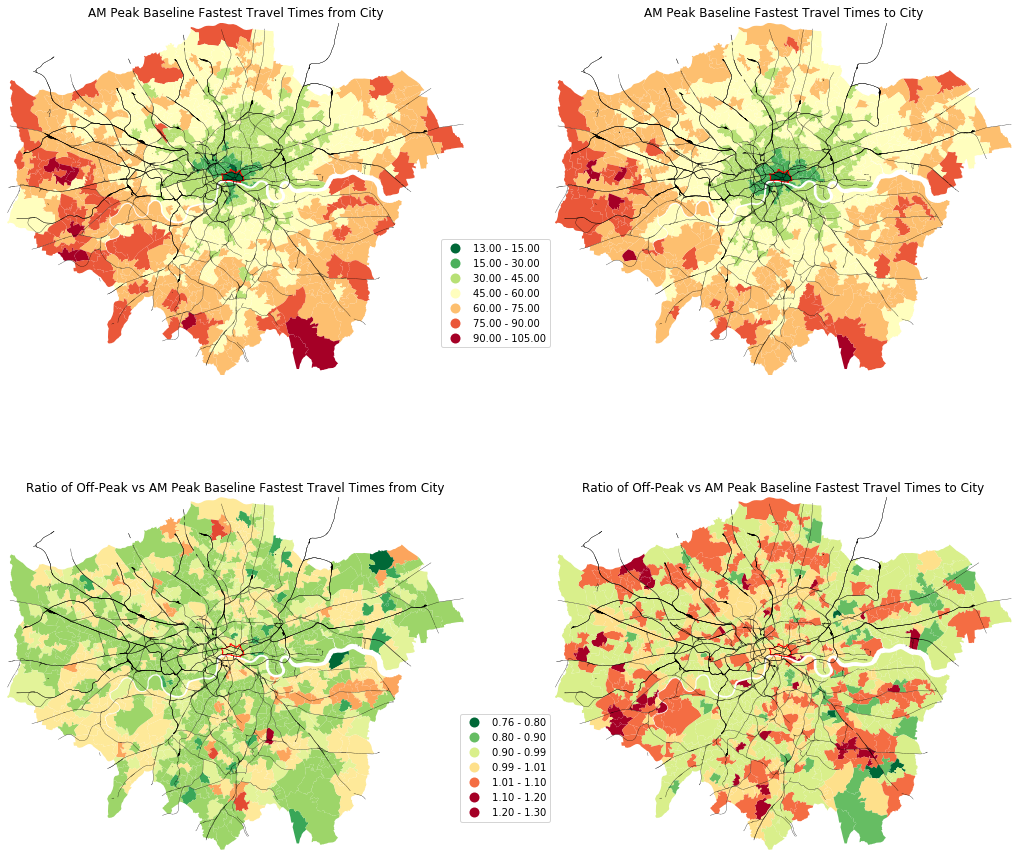

In [9]:
# plot map
fig01 = plt.figure(figsize = (18,16))
ax01_01 = fig01.add_subplot(2,2,1)
set_zoom(ax01_01, msoas)
baseline_fastestoption_ampeak_from_city.plot(column = 'MIN(traveltime)', ax = ax01_01, legend = False, scheme = 'userdefined', 
                                             classification_kwds={'bins':[15, 30, 45, 60, 75, 90, 105]}, cmap = 'RdYlGn_r') # travel times
baseline_fastestoption_ampeak_from_city.loc[['E02000001'],:].plot(facecolor = 'none', edgecolor = 'red', ax = ax01_01) # plot City's location
londonrail.plot(color = 'black', linewidth = .3, ax = ax01_01) # rail lines
londontube.plot(color = 'black', linewidth = .3, ax = ax01_01)
plt.title('AM Peak Baseline Fastest Travel Times from City')
plt.axis('off')

ax01_02 = fig01.add_subplot(2,2,2)
set_zoom(ax01_02, msoas)
baseline_fastestoption_ampeak_to_city.plot(column = 'MIN(traveltime)', ax = ax01_02, scheme = 'userdefined', legend = True,
                                             classification_kwds = {'bins':[15, 30, 45, 60, 75, 90, 105]}, cmap = 'RdYlGn_r')
baseline_fastestoption_ampeak_to_city.loc[['E02000001'],:].plot(facecolor = 'none', edgecolor = 'red', ax = ax01_02)
londonrail.plot(color = 'black', linewidth = .3, ax = ax01_02)
londontube.plot(color = 'black', linewidth = .3, ax = ax01_02)
plt.title('AM Peak Baseline Fastest Travel Times to City')
legend01_02 = ax01_02.get_legend()
legend01_02.set_bbox_to_anchor((0,.4))
plt.axis('off')

ax01_03 = fig01.add_subplot(2,2,3)
set_zoom(ax01_03, msoas)
baseline_fastestoption_offpeak_from_city.plot(column = 'traveltime_offpeak_vs_ampeak', ax = ax01_03, scheme = 'userdefined', legend = False,
                                             classification_kwds = {'bins':[.8,.9,.99,1.01,1.1,1.2,1.3]}, cmap = 'RdYlGn_r')
baseline_fastestoption_ampeak_from_city.loc[['E02000001'],:].plot(facecolor = 'none', edgecolor = 'red', ax = ax01_03)
londonrail.plot(color = 'black', linewidth = .3, ax = ax01_03)
londontube.plot(color = 'black', linewidth = .3, ax = ax01_03)
plt.title('Ratio of Off-Peak vs AM Peak Baseline Fastest Travel Times from City')
plt.axis('off')

ax01_04 = fig01.add_subplot(2,2,4)
set_zoom(ax01_04, msoas)
baseline_fastestoption_offpeak_to_city.plot(column = 'traveltime_offpeak_vs_ampeak', ax = ax01_04, scheme = 'userdefined', legend = True,
                                             classification_kwds = {'bins':[.8,.9,.99,1.01,1.1,1.2,1.3]}, cmap = 'RdYlGn_r')
baseline_fastestoption_ampeak_to_city.loc[['E02000001'],:].plot(facecolor = 'none', edgecolor = 'red', ax = ax01_04)
londonrail.plot(color = 'black', linewidth = .3, ax = ax01_04)
londontube.plot(color = 'black', linewidth = .3, ax = ax01_04)
plt.title('Ratio of Off-Peak vs AM Peak Baseline Fastest Travel Times to City')
legend01_04 = ax01_04.get_legend()
legend01_04.set_bbox_to_anchor((0,.4))
plt.axis('off')

### Fig XX: AM Peak Jobs Reachable Curve from Stratford

In [10]:
with open('../90 Data/compiled secondary data/jobcounts', 'rb') as infile:
    jobcounts = pickle.load(infile)
jobcounts = jobcounts.loc[msoas.index,:] # soet the jobcounts according to MSOA ID

In [11]:
# compile travel times from Stratford and job counts
baseline_fastestoption_ampeak_from_stratford = compile_single_msoa_traveltimes('from', 'E02000726', baseline_fastestoption_ampeak)
baseline_fastestoption_ampeak_from_stratford = baseline_fastestoption_ampeak_from_stratford.join(jobcounts[['Jobs_Total']])

# sort by travel time and calculate cumulative jobs reachable
baseline_fastestoption_ampeak_from_stratford = baseline_fastestoption_ampeak_from_stratford.sort_values(by = 'MIN(traveltime)')
baseline_fastestoption_ampeak_from_stratford['Cumulative_Jobs_Reachable'] = baseline_fastestoption_ampeak_from_stratford['Jobs_Total'].cumsum()

# generate dot density map for jobs
count_per_point = 2000
jobpoints = gpd.GeoDataFrame(gen_points_in_gdf_polys(msoas.geometry, baseline_fastestoption_ampeak_from_stratford['Jobs_Total'], points_per_value = count_per_point))

Text(0, 0.5, 'Cumulative Number of Jobs Reachable\nwithin Travel Time')

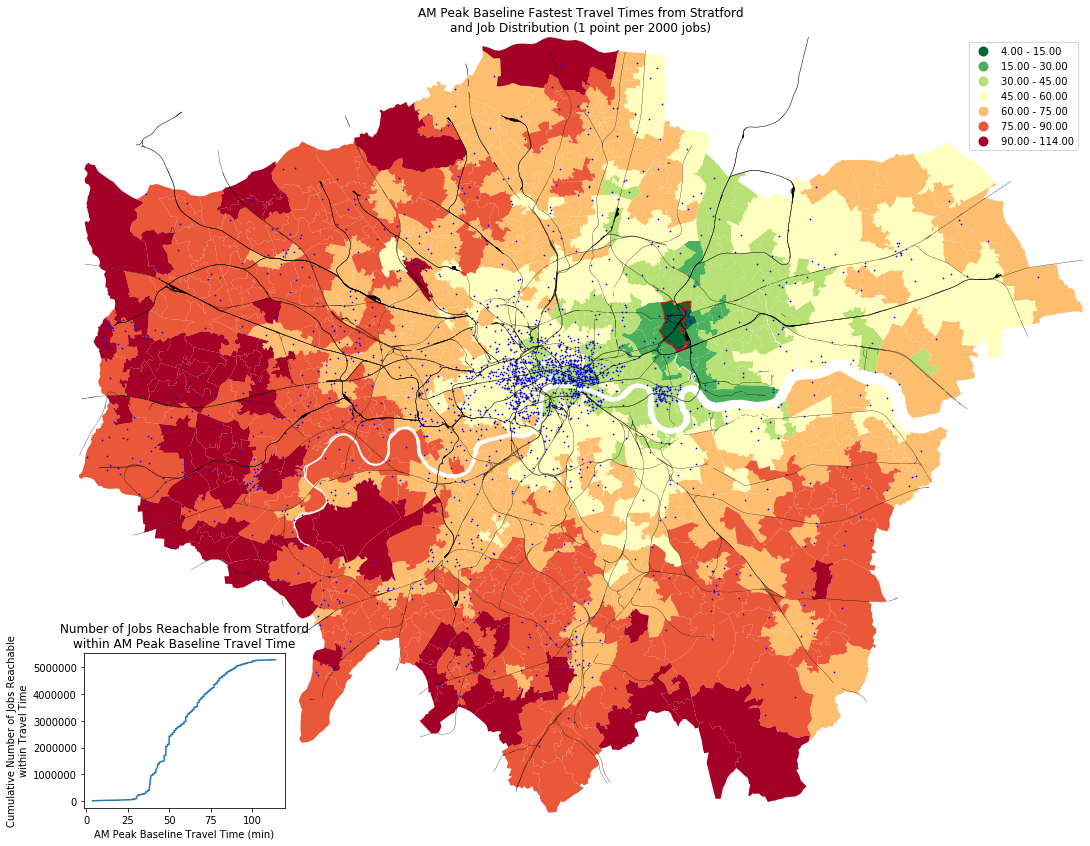

In [12]:
# plot figures
fig02 = plt.figure(figsize = (18,16))
ax02_01 = fig02.add_subplot(1,1,1)
set_zoom(ax02_01, msoas)
baseline_fastestoption_ampeak_from_stratford.plot(column = 'MIN(traveltime)', ax = ax02_01, scheme = 'userdefined', legend = True,
                                                  classification_kwds = {'bins':[15,30,45,60,75,90]}, cmap = 'RdYlGn_r') # travel times
jobpoints.plot(color = 'blue', ax = ax02_01, markersize = .5) # dot density of jobs
londontube.plot(color = 'black', ax = ax02_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax02_01, linewidth = .3)
baseline_fastestoption_ampeak_from_stratford.loc[['E02000726'],:].plot(facecolor = 'none', edgecolor = 'red', ax = ax02_01) # location of Stratford
plt.title('AM Peak Baseline Fastest Travel Times from Stratford\nand Job Distribution (1 point per ' + str(count_per_point) + ' jobs)')
plt.axis('off')

ax02_02 = inset_axes(ax02_01, width = '20%', height = '20%', loc = 3)
ax02_02.plot(baseline_fastestoption_ampeak_from_stratford['MIN(traveltime)'],baseline_fastestoption_ampeak_from_stratford['Cumulative_Jobs_Reachable'])
plt.title('Number of Jobs Reachable from Stratford\nwithin AM Peak Baseline Travel Time')
ax02_02.set_xlabel('AM Peak Baseline Travel Time (min)')
ax02_02.set_ylabel('Cumulative Number of Jobs Reachable\nwithin Travel Time')

### Fig XX: Cumulative Jobs Reachable Curves for all MSOAs

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

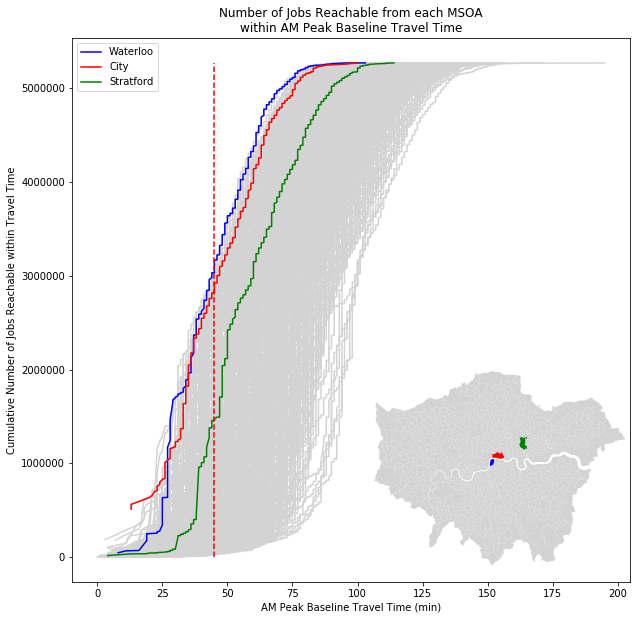

In [13]:
fig03 = plt.figure(figsize = (10,10))
ax03_01 = fig03.add_subplot(111)

for msoa in msoas.index:
    # compile travel times from target MSOA and job counts
    baseline_fastestoption_ampeak_from_msoa = compile_single_msoa_traveltimes('from', msoa, baseline_fastestoption_ampeak)
    baseline_fastestoption_ampeak_from_msoa = baseline_fastestoption_ampeak_from_msoa.join(jobcounts[['Jobs_Total']])

    # sort by travel time and calculate cumulative jobs reachable
    baseline_fastestoption_ampeak_from_msoa = baseline_fastestoption_ampeak_from_msoa.sort_values(by = 'MIN(traveltime)')
    baseline_fastestoption_ampeak_from_msoa['Cumulative_Jobs_Reachable'] = baseline_fastestoption_ampeak_from_msoa['Jobs_Total'].cumsum()
    
    # plot curve to axis
    ax03_01.plot(baseline_fastestoption_ampeak_from_msoa['MIN(traveltime)'],baseline_fastestoption_ampeak_from_msoa['Cumulative_Jobs_Reachable'], color = 'lightgrey')

# plot 3 significant MSOAs
plottingsettings = {'E02006801': {'name': 'Waterloo', 'colour': 'blue'},
                    'E02000001': {'name': 'City', 'colour': 'red'},
                    'E02000726': {'name': 'Stratford', 'colour': 'green'}}
for msoa in plottingsettings.keys():
    # compile travel times from target MSOA and job counts
    baseline_fastestoption_ampeak_from_msoa = compile_single_msoa_traveltimes('from', msoa, baseline_fastestoption_ampeak)
    baseline_fastestoption_ampeak_from_msoa = baseline_fastestoption_ampeak_from_msoa.join(jobcounts[['Jobs_Total']])

    # sort by travel time and calculate cumulative jobs reachable
    baseline_fastestoption_ampeak_from_msoa = baseline_fastestoption_ampeak_from_msoa.sort_values(by = 'MIN(traveltime)')
    baseline_fastestoption_ampeak_from_msoa['Cumulative_Jobs_Reachable'] = baseline_fastestoption_ampeak_from_msoa['Jobs_Total'].cumsum()
    
    # plot curve to axis
    ax03_01.plot(baseline_fastestoption_ampeak_from_msoa['MIN(traveltime)'],baseline_fastestoption_ampeak_from_msoa['Cumulative_Jobs_Reachable'], 
                 color = plottingsettings[msoa]['colour'], label = plottingsettings[msoa]['name'])

ax03_01.plot([45,45],[0,np.sum(jobcounts['Jobs_Total'])], 'r--') # add 45min line    
ax03_01.legend(loc = 'upper left')
plt.title('Number of Jobs Reachable from each MSOA\nwithin AM Peak Baseline Travel Time')
ax03_01.set_xlabel('AM Peak Baseline Travel Time (min)')
ax03_01.set_ylabel('Cumulative Number of Jobs Reachable within Travel Time')

# add inset with locations of 3 significant MSOAs
ax03_02 = inset_axes(ax03_01, width = '45%', height = '40%', loc = 4)
set_zoom(ax03_02, msoas)
msoas.plot(ax = ax03_02, color = 'lightgrey')
for msoa in plottingsettings.keys():
    msoas.loc[[msoa],:].plot(ax = ax03_02, color = plottingsettings[msoa]['colour'])
plt.axis('off')

###  Fig XX: Reach to Jobs within 45min

In [14]:
with open('../90 Data/compiled secondary data/imd_msoa', 'rb') as infile:
    imd_msoa = pickle.load(infile)
imd_msoa = imd_msoa.loc[msoas.index,:]

In [15]:
# compile ampeak reach data
## convert long-form travel time matrix to wide-form
ttm_baseline_ampeak = baseline_fastestoption_ampeak.pivot_table(index = 'orig_id', columns = 'dest_id', values = 'MIN(traveltime)')
## for each cell in the ttm, return 1 if travel time is within the cutoff, otherwise return zero. this makes an accessibility matrix.
## then take the dot product of the accessibility matrix with the column vector of jobs per MSOA, which returns the sum of the jobs in MSOAs that are accessible for each row in the accessibility matrix.
reach_to_jobs_ampeak = pd.DataFrame({'Jobs Reachable within ' + str(traveltime_cutoff) + 'min': (ttm_baseline_ampeak <= traveltime_cutoff).dot(jobcounts['Jobs_Total'])},
                                    index = jobcounts.index)
reach_to_jobs_ampeak['PC Jobs Reachable within ' + str(traveltime_cutoff) + 'min'] = reach_to_jobs_ampeak['Jobs Reachable within ' + str(traveltime_cutoff) + 'min'] / np.sum(jobcounts['Jobs_Total'])
reach_to_jobs_ampeak = msoas.join(reach_to_jobs_ampeak)

# compile offpeak reach data
ttm_baseline_offpeak = baseline_fastestoption_offpeak.pivot_table(index = 'orig_id', columns = 'dest_id', values = 'MIN(traveltime)')
reach_to_jobs_offpeak = pd.DataFrame({'Jobs Reachable within ' + str(traveltime_cutoff) + 'min': (ttm_baseline_offpeak <= traveltime_cutoff).dot(jobcounts['Jobs_Total'])},
                                     index = jobcounts.index)
reach_to_jobs_offpeak['PC Jobs Reachable within ' + str(traveltime_cutoff) + 'min'] = reach_to_jobs_offpeak['Jobs Reachable within ' + str(traveltime_cutoff) + 'min'] / np.sum(jobcounts['Jobs_Total'])
reach_to_jobs_offpeak['Reach to Jobs Offpeak vs AMPeak'] = reach_to_jobs_offpeak['Jobs Reachable within ' + str(traveltime_cutoff) + 'min'] / reach_to_jobs_ampeak['Jobs Reachable within ' + str(traveltime_cutoff) + 'min']
reach_to_jobs_offpeak = msoas.join(reach_to_jobs_offpeak)

Text(0, 0.5, 'Index of Multiple Deprivation Rank (lower is more deprived)')

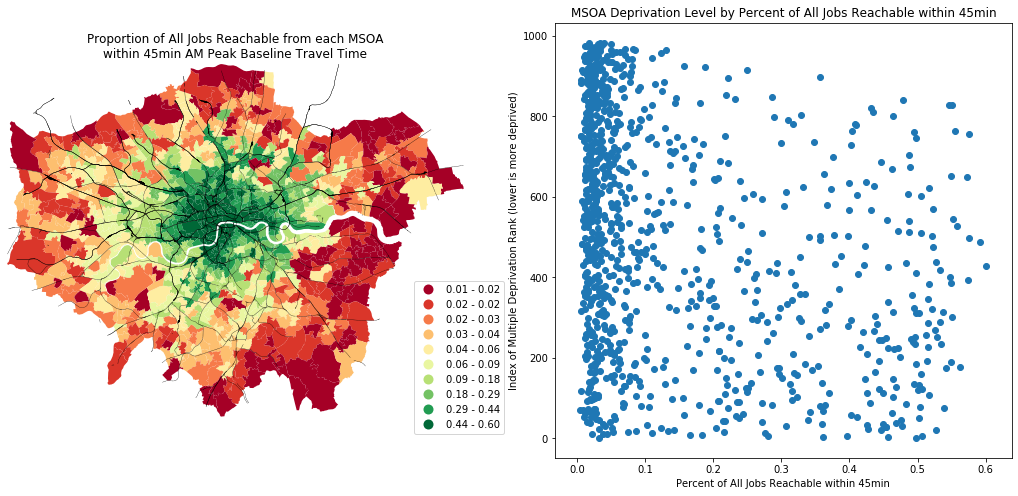

In [16]:
# plot map
fig04 = plt.figure(figsize = (18,8))
ax04_01 = fig04.add_subplot(1,2,1)
set_zoom(ax04_01, msoas)
reach_to_jobs_ampeak.plot(column = 'PC Jobs Reachable within ' + str(traveltime_cutoff) + 'min', scheme = 'quantiles', k = 10, cmap = 'RdYlGn', 
                          legend = True, ax = ax04_01) # reach to jobs data
londontube.plot(color = 'black', ax = ax04_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax04_01, linewidth = .3)
legend04_01 = ax04_01.get_legend()
legend04_01.set_bbox_to_anchor((1.1,.4))
plt.title('Proportion of All Jobs Reachable from each MSOA\nwithin 45min AM Peak Baseline Travel Time')
plt.axis('off')

ax04_02 = fig04.add_subplot(1,2,2)
ax04_02.scatter(x = reach_to_jobs_ampeak['PC Jobs Reachable within ' + str(traveltime_cutoff) + 'min'], y = imd_msoa['Index of Multiple Deprivation (IMD) Rank'])
plt.title('MSOA Deprivation Level by Percent of All Jobs Reachable within ' + str(traveltime_cutoff) + 'min')
ax04_02.set_xlabel('Percent of All Jobs Reachable within ' + str(traveltime_cutoff) + 'min')
ax04_02.set_ylabel('Index of Multiple Deprivation Rank (lower is more deprived)')

In [17]:
with open('../90 Data/compiled secondary data/housing', 'rb') as infile:
    housing = pickle.load(infile)
housing = housing.loc[msoas.index,:] # sort housing by MSOA IDs
housing = housing.join(reach_to_jobs_ampeak['PC Jobs Reachable within ' + str(traveltime_cutoff) + 'min'])

Text(0, 0.5, 'Council Tax Bands')

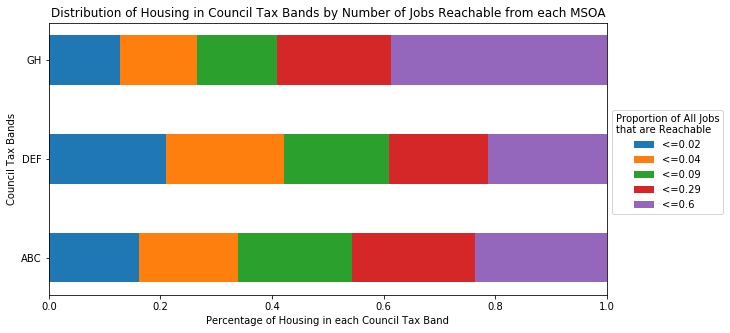

In [18]:
reach_quantiles = np.quantile(reach_to_jobs_ampeak['PC Jobs Reachable within ' + str(traveltime_cutoff) + 'min'], q = [.2,.4,.6,.8,1])
# assign each MSOA to jobs reachable quantile
housing['Jobs Reachable Quantile'] = 0
for i in range(len(reach_quantiles)):
    housing.loc[housing['PC Jobs Reachable within ' + str(traveltime_cutoff) + 'min'] > reach_quantiles[i], 'Jobs Reachable Quantile'] = i + 1

# calculate proportion of each housing type in each jobs reachable quantile
housing_by_jobs_reachable_quantiles = housing[['ABC','DEF','GH','Jobs Reachable Quantile']].groupby('Jobs Reachable Quantile').sum().apply(lambda x: x/x.sum())
for col in housing_by_jobs_reachable_quantiles.columns:
    housing_by_jobs_reachable_quantiles[col + '_CumSum'] = housing_by_jobs_reachable_quantiles[col].cumsum()

# plot figure
fig07 = plt.figure(figsize = (10,5))
ax07_01 = fig07.add_subplot(111)
ax07_01.set_xlim(0,1)
for quantile in housing_by_jobs_reachable_quantiles.index:
    ax07_01.barh(y = list(housing_by_jobs_reachable_quantiles.columns[:3]),
                 width = housing_by_jobs_reachable_quantiles.loc[quantile,['ABC','DEF','GH']],
                 left = housing_by_jobs_reachable_quantiles.loc[quantile,['ABC_CumSum','DEF_CumSum','GH_CumSum']].values - housing_by_jobs_reachable_quantiles.loc[quantile,['ABC','DEF','GH']].values,
                 label = '<=' + str(round(reach_quantiles[quantile],2)), height = .5)
plt.legend(title = 'Proportion of All Jobs\nthat are Reachable', bbox_to_anchor = (1,.7))
plt.title('Distribution of Housing in Council Tax Bands by Number of Jobs Reachable from each MSOA')
ax07_01.set_xlabel('Percentage of Housing in each Council Tax Band')
ax07_01.set_ylabel('Council Tax Bands')

In [19]:
list(housing_by_jobs_reachable_quantiles.columns)[:4]

['ABC', 'DEF', 'GH', 'ABC_CumSum']

### Fig XX: Job Provision Ratios

In [20]:
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)
popcounts = popcounts.loc[msoas.index,:] # sort popcounts by MSOA IDs

In [21]:
def calculate_provision_ratios(users, targets, ttm, traveltime_cutoff):
    '''Allocates target amenities to users among n areas using a modified cumulative accessibility measure that accounts 
    for competition effects.
    users is a n x 1 dataframe of the number of users per area for a particular amenity, targets is a n x 1 dataframe of 
    the number of target amenities per area, ttm is a n origins x n destinations travel time matrix, traveltime_cutoff is 
    the maximum travel time (inclusive) for a destination to be considered accessible from an origin.'''
    # ensure ttm, users and targets are sorted in the same order
    provision_ratios = users.loc[ttm.index,:].join(targets.loc[ttm.index,:])
    # calculate for each area, how many clients can reach it - note need to transpose the TTM to summarise to destinations instead of origins
    provision_ratios['Users Who Can Access'] = (ttm.transpose() <= traveltime_cutoff).dot(provision_ratios.iloc[:,0])
    # then divide the number of targets in each area evenly among all users who can reach it
    provision_ratios['Targets per User Who Can Access'] = provision_ratios.iloc[:,1] / provision_ratios['Users Who Can Access']
    # then sum up the number of targets per client who can reach each area to each origin
    provision_ratios['Targets within ' + str(traveltime_cutoff) + 'min per User'] = (ttm <= traveltime_cutoff).dot(provision_ratios['Targets per User Who Can Access'])
    # checking that all jobs have been allocated exactly once to reachable workers
    provision_ratios['Targets Allocated to Users'] = provision_ratios['Targets within ' + str(traveltime_cutoff) + 'min per User'] * provision_ratios.iloc[:,0]
    print('All targets allocated exactly once to reachable users:', np.sum(provision_ratios['Targets Allocated to Users']) == np.sum(targets))
    
    return provision_ratios

In [22]:
jpr_ampeak_baseline = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts[['Jobs_Total']], ttm_baseline_ampeak, traveltime_cutoff)
jpr_ampeak_baseline = msoas.join(jpr_ampeak_baseline)
jpr_offpeak_baseline = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts[['Jobs_Total']], ttm_baseline_offpeak, traveltime_cutoff)
jpr_offpeak_baseline = msoas.join(jpr_offpeak_baseline)

All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool
All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool


Text(0, 0.5, 'Index of Multiple Deprivation Rank (lower is more deprived)')

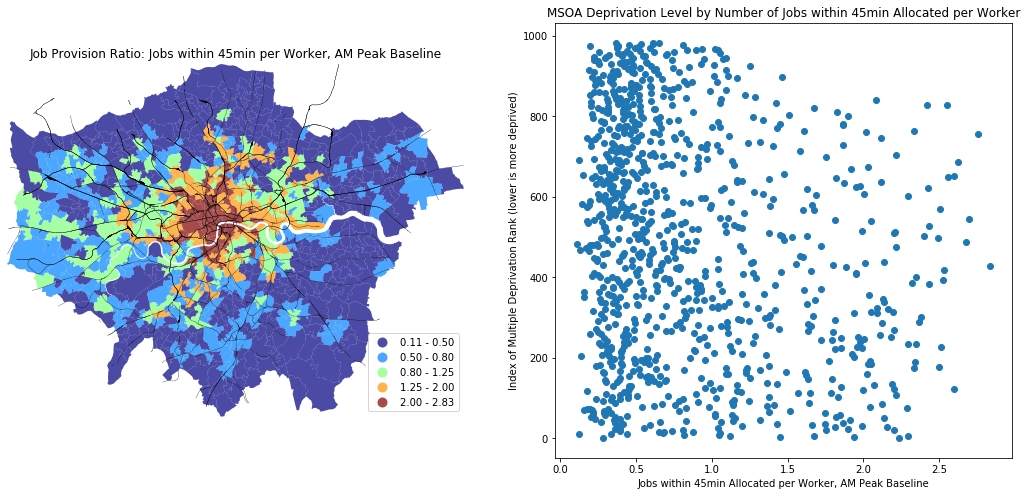

In [23]:
# plot map
fig05 = plt.figure(figsize = (18,8))
ax05_01 = fig05.add_subplot(1,2,1)
set_zoom(ax05_01, msoas)
jpr_ampeak_baseline.plot(column = 'Targets within ' + str(traveltime_cutoff) + 'min per User', ax = ax05_01, 
                         scheme = 'userdefined', 
                         classification_kwds = {'bins':[.5,.8,1.25,2]}, 
                         cmap = 'jet', legend = True, alpha = .7)
londontube.plot(color = 'black', ax = ax05_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax05_01, linewidth = .3)
plt.title('Job Provision Ratio: Jobs within ' + str(traveltime_cutoff) + 'min per Worker, AM Peak Baseline')
legend05_01 = ax05_01.get_legend()
legend05_01.set_bbox_to_anchor((1,.25))
plt.axis('off')

ax05_02 = fig05.add_subplot(1,2,2)
ax05_02.scatter(x = jpr_ampeak_baseline['Targets within ' + str(traveltime_cutoff) + 'min per User'],
                y = imd_msoa['Index of Multiple Deprivation (IMD) Rank'])
plt.title('MSOA Deprivation Level by Number of Jobs within ' + str(traveltime_cutoff) + 'min Allocated per Worker')
ax05_02.set_xlabel('Jobs within 45min Allocated per Worker, AM Peak Baseline')
ax05_02.set_ylabel('Index of Multiple Deprivation Rank (lower is more deprived)')

In [24]:
housing = housing.join(jpr_ampeak_baseline['Targets within ' + str(traveltime_cutoff) + 'min per User'])

Text(0, 0.5, 'Council Tax Bands')

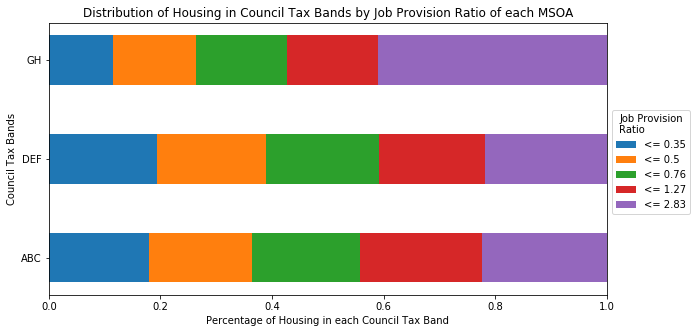

In [25]:
jpr_quantiles = np.quantile(jpr_ampeak_baseline['Targets within ' + str(traveltime_cutoff) + 'min per User'], q = [.2,.4,.6,.8,1])
# assign each MSOA to jobs reachable quantile
housing['JPR Quantile'] = 0
for i in range(len(jpr_quantiles)):
    housing.loc[housing['Targets within ' + str(traveltime_cutoff) + 'min per User'] > jpr_quantiles[i], 'JPR Quantile'] = i + 1

# calculate proportion of each housing type in each jobs reachable quantile
housing_by_jpr_quantiles = housing[['ABC','DEF','GH','JPR Quantile']].groupby('JPR Quantile').sum().apply(lambda x: x/x.sum())
for col in housing_by_jpr_quantiles.columns:
    housing_by_jpr_quantiles[col + '_CumSum'] = housing_by_jpr_quantiles[col].cumsum()

# plot figure
fig08 = plt.figure(figsize = (10,5))
ax08_01 = fig08.add_subplot(111)
ax08_01.set_xlim(0,1)
for quantile in housing_by_jpr_quantiles.index:
    ax08_01.barh(y = list(housing_by_jpr_quantiles.columns[:3]),
                 width = housing_by_jpr_quantiles.loc[quantile,['ABC','DEF','GH']],
                 left = housing_by_jpr_quantiles.loc[quantile,['ABC_CumSum','DEF_CumSum','GH_CumSum']].values - housing_by_jpr_quantiles.loc[quantile,['ABC','DEF','GH']].values,
                 label = '<= ' + str(round(jpr_quantiles[quantile], 2)), height = .5)
plt.legend(title = 'Job Provision\nRatio', bbox_to_anchor = (1,.7))
plt.title('Distribution of Housing in Council Tax Bands by Job Provision Ratio of each MSOA')
ax08_01.set_xlabel('Percentage of Housing in each Council Tax Band')
ax08_01.set_ylabel('Council Tax Bands')

### Fig XX: Shannon Diversity of Jobs Allocated per Worker by Sector

In [26]:
# aggregate 21 industrial sectors to 6 overarching sectors
jobcounts_aggregated_sectors = pd.DataFrame(index = jobcounts.index)
jobcounts_aggregated_sectors['Primary, Extractive'] = np.sum(jobcounts[['Jobs_Agriculture', 'Jobs_Mining']], axis = 1)
jobcounts_aggregated_sectors['Industrial'] = np.sum(jobcounts[['Jobs_Manufacturing',
       'Jobs_Energy_Utilities', 'Jobs_Water_Utilities', 'Jobs_Construction',]], axis = 1)
jobcounts_aggregated_sectors['Retail, Logistics, F&B, Hospitality'] = np.sum(jobcounts[['Jobs_Wholesale_Retail', 'Jobs_Transport_Storage', 
       'Jobs_Accom_Food']], axis = 1)
jobcounts_aggregated_sectors['FIRE, Professional, Admin'] = np.sum(jobcounts[['Jobs_Infocomm', 'Jobs_Finance_Insurance', 'Jobs_Real_Estate',
       'Jobs_Professional_Scientific_Technical', 'Jobs_Administrative_Support']], axis = 1)
jobcounts_aggregated_sectors['Public Sector'] = np.sum(jobcounts[['Jobs_Public_Admin_Defence', 'Jobs_Education',
       'Jobs_Health_Social_Work']], axis = 1)
jobcounts_aggregated_sectors['Others'] = np.sum(jobcounts[['Jobs_Arts_Entertainment',
       'Jobs_Other_Services', 'Jobs_Household', 'Jobs_Extraterrestrial_Orgs']], axis = 1)
# check that aggregation did not miss out any jobs
print('All jobs aggregated correctly to larger sectors:', np.sum(np.sum(jobcounts_aggregated_sectors)) == np.sum(jobcounts['Jobs_Total']))

All jobs aggregated correctly to larger sectors: True


In [27]:
# calculating Shannon diversity
sector_diversity = pd.DataFrame(columns = jobcounts_aggregated_sectors.columns)
# calculate p_i for each sector i
for sector in jobcounts_aggregated_sectors.columns:
    sector_diversity[sector] = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts_aggregated_sectors[[sector]], ttm_baseline_ampeak, traveltime_cutoff).iloc[:,-2] / jpr_ampeak_baseline['Targets within 45min per User']
# calculating -sum(p_i ln p_i) as from https://en.wikipedia.org/wiki/Diversity_index#Shannon_index
sector_diversity['Shannon Diversity'] = -np.sum(sector_diversity * sector_diversity.apply(np.log), axis = 1)

sector_diversity = msoas.join(sector_diversity)

All targets allocated exactly once to reachable users: Primary, Extractive    True
dtype: bool
All targets allocated exactly once to reachable users: Industrial    True
dtype: bool
All targets allocated exactly once to reachable users: Retail, Logistics, F&B, Hospitality    True
dtype: bool
All targets allocated exactly once to reachable users: FIRE, Professional, Admin    True
dtype: bool
All targets allocated exactly once to reachable users: Public Sector    True
dtype: bool
All targets allocated exactly once to reachable users: Others    True
dtype: bool


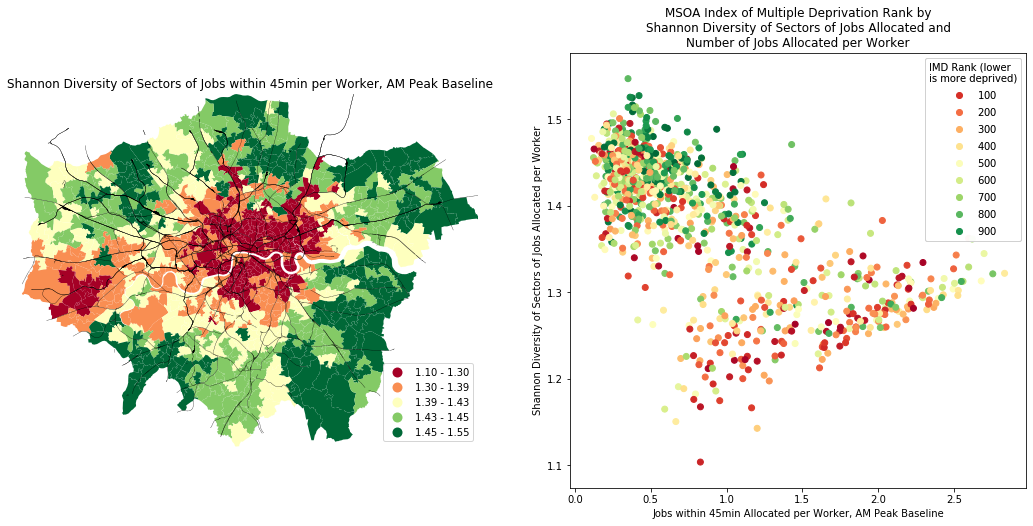

In [28]:
# plot map
fig06 = plt.figure(figsize = (18,8))
ax06_01 = fig06.add_subplot(1,2,1)
set_zoom(ax06_01, msoas)
sector_diversity.plot(column = 'Shannon Diversity', ax = ax06_01, scheme = 'quantiles', k = 5, cmap = 'RdYlGn', legend = True) # Shannon diversity
londontube.plot(color = 'black', ax = ax06_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax06_01, linewidth = .3)
legend06_01 = ax06_01.get_legend()
legend06_01.set_bbox_to_anchor((1,.25))
plt.title('Shannon Diversity of Sectors of Jobs within ' + str(traveltime_cutoff) + 'min per Worker, AM Peak Baseline')
plt.axis('off')

ax06_02 = fig06.add_subplot(1,2,2)
scatter06_02 = ax06_02.scatter(x = jpr_ampeak_baseline['Targets within 45min per User'], y = sector_diversity['Shannon Diversity'], c = imd_msoa['Index of Multiple Deprivation (IMD) Rank'], cmap = 'RdYlGn')
plt.title('MSOA Index of Multiple Deprivation Rank by\nShannon Diversity of Sectors of Jobs Allocated and\nNumber of Jobs Allocated per Worker')
ax06_02.set_xlabel('Jobs within 45min Allocated per Worker, AM Peak Baseline')
ax06_02.set_ylabel('Shannon Diversity of Sectors of Jobs Allocated per Worker')
legend06_02 = ax06_02.legend(*scatter06_02.legend_elements(), title = 'IMD Rank (lower\nis more deprived)')
ax06_02.add_artist(legend06_02)

### KMeans Clustering of MSOAs by IMD and Job Allocation by Sector

In [29]:
# KMeans clustering for IMD and jobs allocated by sector
kmeans_data = pd.DataFrame(columns = jobcounts_aggregated_sectors.columns)
# calculate JPR for each sector i
for sector in jobcounts_aggregated_sectors.columns:
    kmeans_data[sector] = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts_aggregated_sectors[[sector]], ttm_baseline_ampeak, traveltime_cutoff).iloc[:,-2]
kmeans_data = kmeans_data.join(imd_msoa[['Index of Multiple Deprivation (IMD) Rank']])
# create version of data with columns standardised for KMeans clustering
kmeans_data_standardised = pd.DataFrame(StandardScaler().fit_transform(X = kmeans_data), columns = kmeans_data.columns, index = kmeans_data.index)

All targets allocated exactly once to reachable users: Primary, Extractive    True
dtype: bool
All targets allocated exactly once to reachable users: Industrial    True
dtype: bool
All targets allocated exactly once to reachable users: Retail, Logistics, F&B, Hospitality    True
dtype: bool
All targets allocated exactly once to reachable users: FIRE, Professional, Admin    True
dtype: bool
All targets allocated exactly once to reachable users: Public Sector    True
dtype: bool
All targets allocated exactly once to reachable users: Others    True
dtype: bool


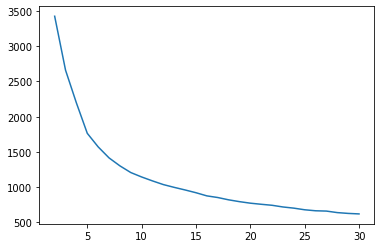

In [30]:
# identify suitable value for k
n_clusters = [i+2 for i in range(29)]
inertias = []
for i in n_clusters:
    inertias.append(KMeans(i, random_state = 1000).fit(kmeans_data_standardised).inertia_)
plt.plot(n_clusters, inertias)

In [31]:
# carry out KMeans clustering
n_clusters = 5
kmeans1 = KMeans(n_clusters, random_state = 6881).fit(kmeans_data_standardised)
# join clustering labels to raw data
kmeans_data = kmeans_data.join(jpr_ampeak_baseline['Targets within 45min per User'])
kmeans_data['kmeans_cluster_' + str(n_clusters)] = kmeans1.labels_

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

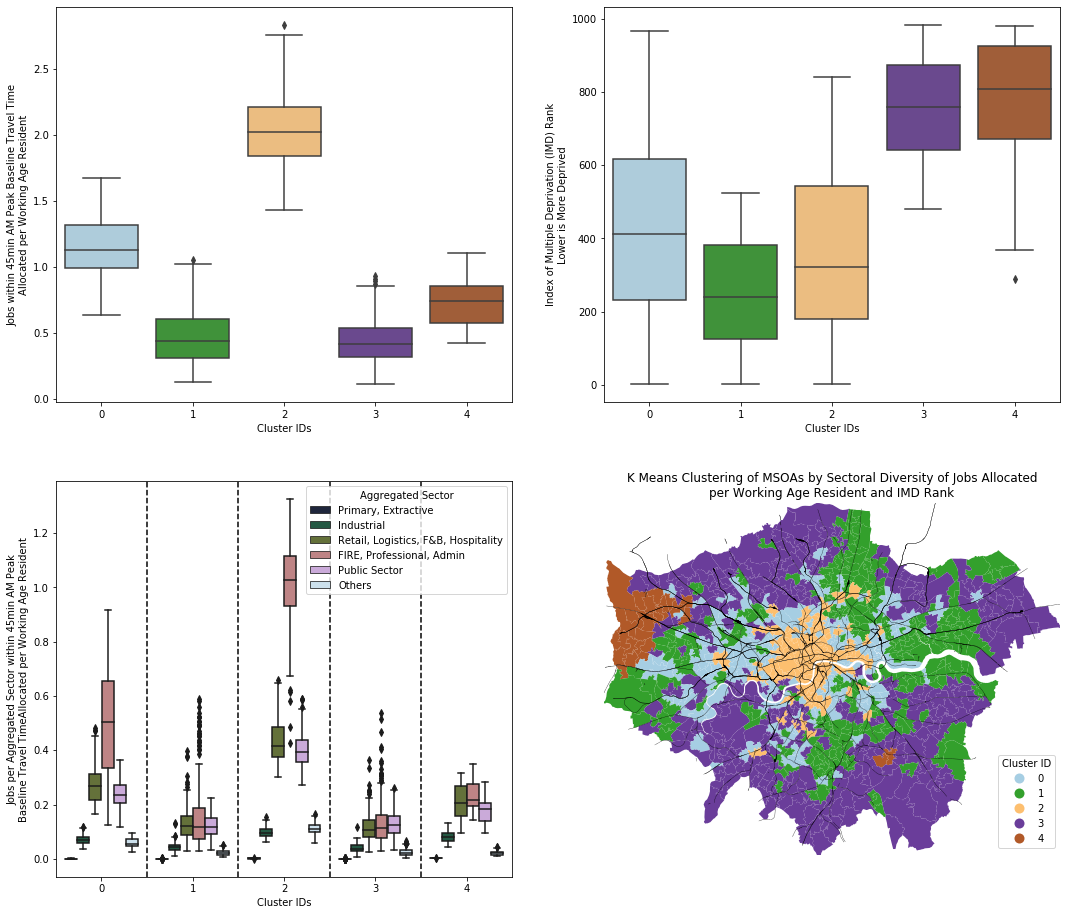

In [32]:
# set colormaps
colormap = []
colors = plt.cm.Paired(np.linspace(0, 1, n_clusters)) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))

# plot data
fig09 = plt.figure(figsize = (18,16))

# boxplot of JPR value distributions per cluster
ax09_01 = fig09.add_subplot(2,2,1)
with sns.color_palette(colormap):
    ax09_01 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Targets within 45min per User', data = kmeans_data)
ax09_01.set_xlabel('Cluster IDs')
ax09_01.set_ylabel('Jobs within 45min AM Peak Baseline Travel Time\nAllocated per Working Age Resident')

# boxplot of IMD ranks per cluster
ax09_02 = fig09.add_subplot(2,2,2)
with sns.color_palette(colormap):
    ax09_02 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Index of Multiple Deprivation (IMD) Rank', data = kmeans_data)
ax09_02.set_xlabel('Cluster IDs')
ax09_02.set_ylabel('Index of Multiple Deprivation (IMD) Rank\nLower is More Deprived')

# boxplot of sectoral JPRs per cluster
ax09_03 = fig09.add_subplot(2,2,3)
kmeans_data2 = pd.melt(kmeans_data[['Primary, Extractive', 'Industrial',
       'Retail, Logistics, F&B, Hospitality',
       'FIRE, Professional, Admin', 'Public Sector',
       'Others']].reset_index(), id_vars = 'orig_id', value_vars = ['Primary, Extractive', 'Industrial',
       'Retail, Logistics, F&B, Hospitality',
       'FIRE, Professional, Admin', 'Public Sector',
       'Others'])
kmeans_data2 = kmeans_data2.merge(kmeans_data[['kmeans_cluster_' + str(n_clusters)]], left_on = 'orig_id', right_index = True)
with sns.color_palette('cubehelix'):
    ax09_03 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'value', hue = 'variable', data = kmeans_data2)
for i in range(n_clusters - 1):
    ax09_03.axvline((i + .5), color = 'black', linestyle = '--')
ax09_03.set_xlabel('Cluster IDs')
ax09_03.set_ylabel('Jobs per Aggregated Sector within 45min AM Peak\nBaseline Travel TimeAllocated per Working Age Resident')
legend09_03 = ax09_03.get_legend()
legend09_03.set_title('Aggregated Sector')

# clustering map
ax09_04 = fig09.add_subplot(2,2,4)
set_zoom(ax09_04, msoas)
msoas.join(kmeans_data).plot(column = 'kmeans_cluster_' + str(n_clusters), ax = ax09_04, cmap = 'Paired', categorical = True, legend = True)
londontube.plot(color = 'black', linewidth = .3, ax = ax09_04)
londonrail.plot(color = 'black', linewidth = .3, ax = ax09_04)
legend09_04 = ax09_04.get_legend()
legend09_04.set_bbox_to_anchor((1,.3))
legend09_04.set_title('Cluster ID')
plt.title('K Means Clustering of MSOAs by Sectoral Diversity of Jobs Allocated\nper Working Age Resident and IMD Rank')
plt.axis('off')

### Write Out Useful Datasets

In [33]:
prepped_data = {'reach_to_jobs_ampeak': reach_to_jobs_ampeak, 
                'reach_to_jobs_offpeak': reach_to_jobs_offpeak, 
                'jpr_ampeak_baseline': jpr_ampeak_baseline,
                'jpr_offpeak_baseline': jpr_offpeak_baseline,
                'sector_diversity': sector_diversity, 
                'jobcounts_aggregated_sectors': jobcounts_aggregated_sectors}

for dataset in prepped_data.keys():
    with open('../90 Data/compiled secondary data/' + dataset, 'wb') as outfile:
        pickle.dump(prepped_data[dataset], outfile)